<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Обучение-CatBoostRegressor" data-toc-modified-id="Обучение-CatBoostRegressor-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Обучение CatBoostRegressor</a></span></li><li><span><a href="#Обучение-DecisionTreeRegressor" data-toc-modified-id="Обучение-DecisionTreeRegressor-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Обучение DecisionTreeRegressor</a></span></li><li><span><a href="#Обучение-RandomForestRegressor" data-toc-modified-id="Обучение-RandomForestRegressor-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Обучение RandomForestRegressor</a></span></li><li><span><a href="#Сравнительная-таблица-тренировочной-выборки" data-toc-modified-id="Сравнительная-таблица-тренировочной-выборки-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Сравнительная таблица тренировочной выборки</a></span></li></ul></li><li><span><a href="#Тестирование-лучшей-модели" data-toc-modified-id="Тестирование-лучшей-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование лучшей модели</a></span><ul class="toc-item"><li><span><a href="#Тестирование-CatBoostRegressor" data-toc-modified-id="Тестирование-CatBoostRegressor-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Тестирование CatBoostRegressor</a></span></li></ul></li><li><span><a href="#Итоговый-вывод" data-toc-modified-id="Итоговый-вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Итоговый вывод</a></span><ul class="toc-item"><li><span><a href="#Открыл-файл-с-данными-и-изучил-иформацию" data-toc-modified-id="Открыл-файл-с-данными-и-изучил-иформацию-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Открыл файл с данными и изучил иформацию</a></span></li><li><span><a href="#Провел-анализ" data-toc-modified-id="Провел-анализ-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Провел анализ</a></span></li><li><span><a href="#Обучил-модели" data-toc-modified-id="Обучил-модели-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Обучил модели</a></span></li><li><span><a href="#Проверил-на-тестовой-выборки" data-toc-modified-id="Проверил-на-тестовой-выборки-5.4"><span class="toc-item-num">5.4&nbsp;&nbsp;</span>Проверил на тестовой выборки</a></span></li></ul></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
!pip install scikit-learn==1.1.3 -q
!pip install lightgbm==3.3.3 -q
!pip install imblearn -q
!pip install mlxtend -q

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings

from statsmodels.tsa.seasonal import seasonal_decompose
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import (
    GridSearchCV, 
    train_test_split, 
    TimeSeriesSplit
)

from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller

plt.rcParams["figure.figsize"] = (15, 10)

warnings.filterwarnings("ignore")

RANDOM_STATE = 37
TEST_SIZE = .1

In [3]:
pth1 = '/datasets/taxi.csv'

if os.path.exists(pth1):
    df = pd.read_csv(pth1, index_col=[0], parse_dates=[0])
else:
    print('Something is wrong')

In [4]:
display(df.head())
df.info()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [5]:
df.index.is_monotonic

True

In [6]:
df = df.resample('1H').sum()
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


**Вывод:** Загрузить данные, в таблице 2 столбца и 26496 строк, проверил, в хронологическом ли порядке расположены даты и время и выполнил их ресемплирование по одному часу.

## Анализ

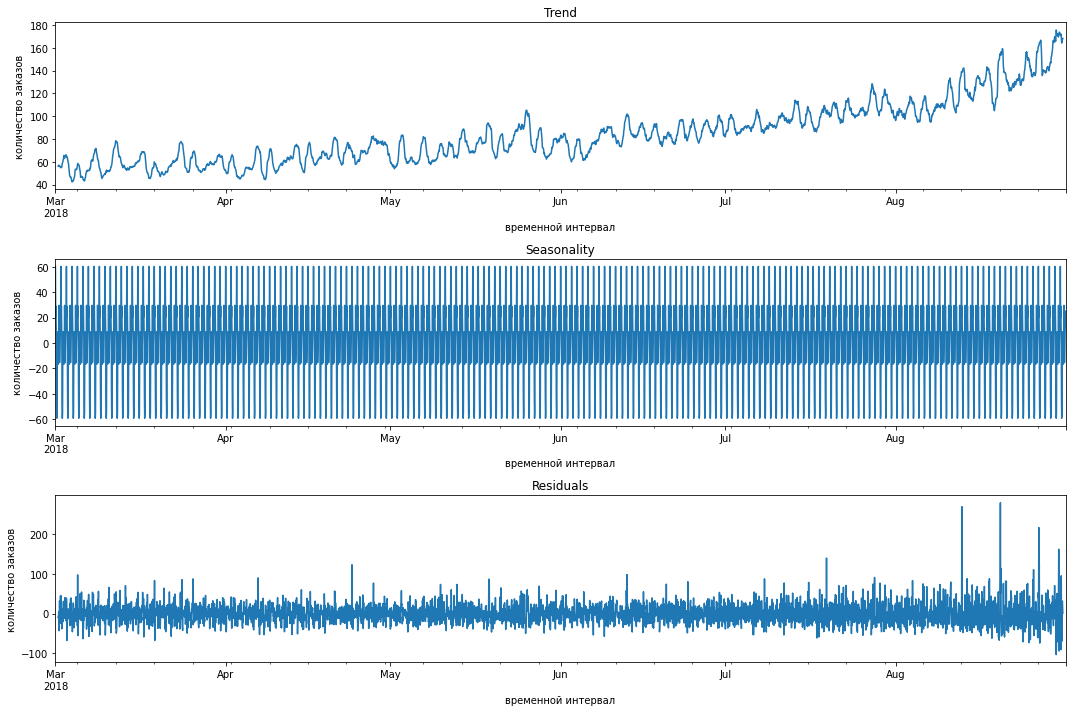

In [7]:
decomposed = seasonal_decompose(df)

plt.figure()
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.xlabel('временной интервал') 
plt.ylabel('количество заказов')
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.xlabel('временной интервал') 
plt.ylabel('количество заказов')
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.xlabel('временной интервал') 
plt.ylabel('количество заказов')
plt.title('Residuals')
plt.tight_layout()

Разложил временной ряд на три составляющие: *тренд*, *сезонность* и *остаток*.Наблюдаю плавный рост *тренда* от начала марта до конца августа. 

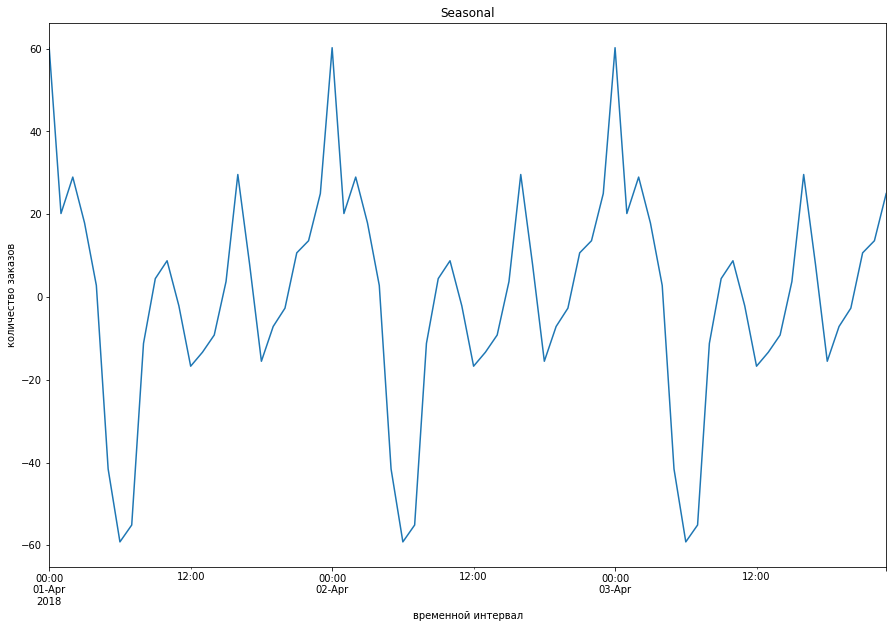

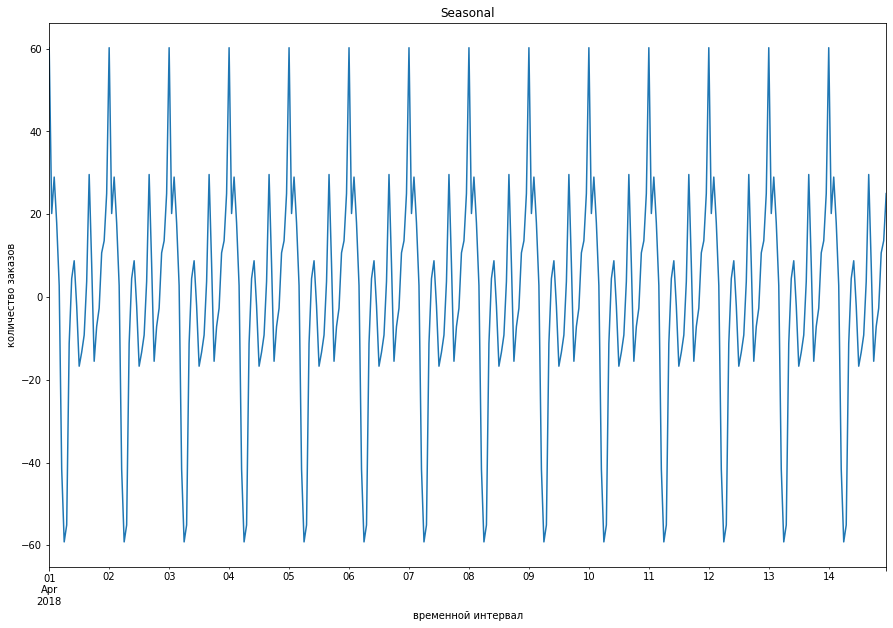

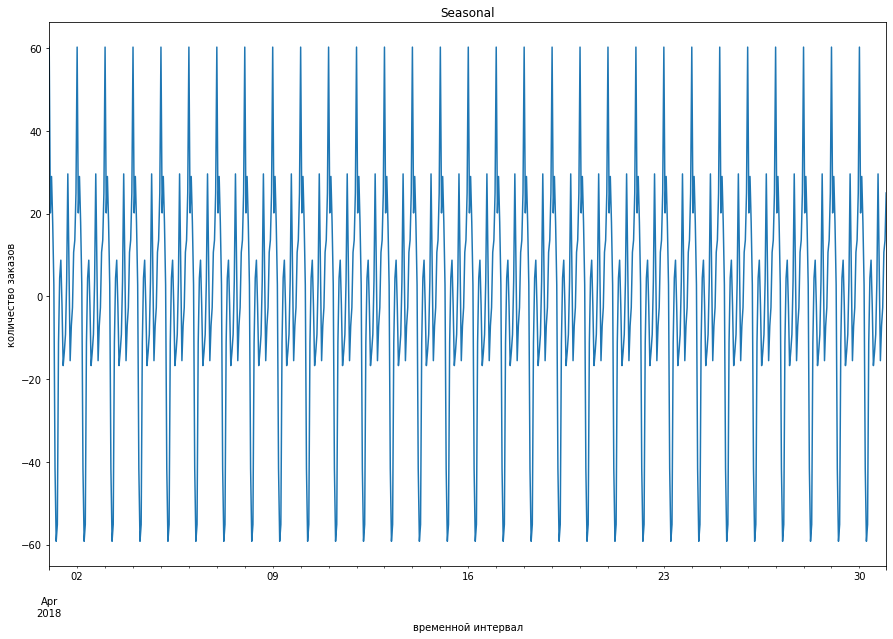

In [8]:
decomposed.seasonal['2018-04-1':'2018-04-3'].plot()
plt.xlabel('временной интервал') 
plt.ylabel('количество заказов')
plt.title('Seasonal')
plt.show()

decomposed.seasonal['2018-04-1':'2018-04-14'].plot()
plt.xlabel('временной интервал') 
plt.ylabel('количество заказов')
plt.title('Seasonal')
plt.show()

decomposed.seasonal['2018-04-1':'2018-04-30'].plot()
plt.xlabel('временной интервал') 
plt.ylabel('количество заказов')
plt.title('Seasonal')
plt.show()

Посмотрел сезонность в разрезе 3-х дней, 2-х недель и месяца.На первом графике видим цикличный подъем с 6 утра до 12 ночи,а после спад до 6 утра.

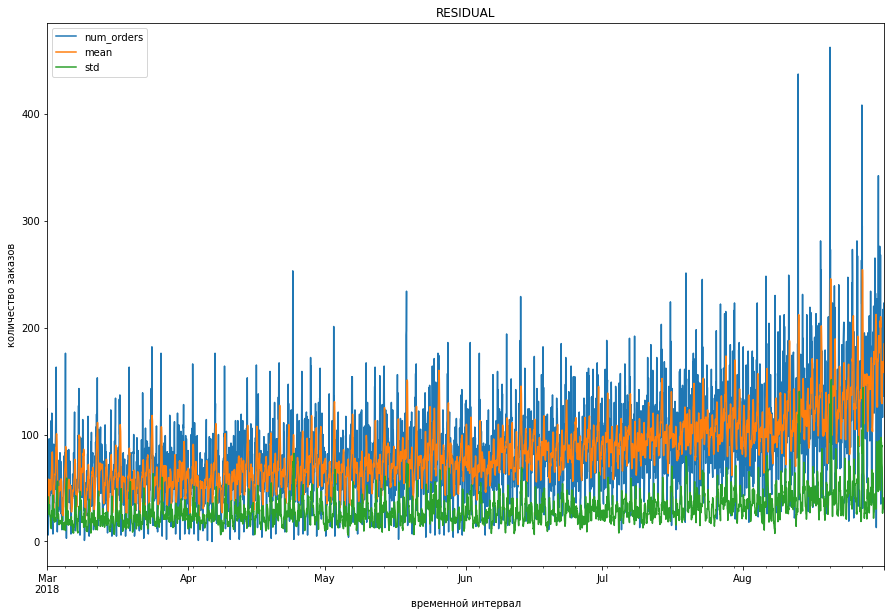

In [9]:
data = df.copy()

data['mean'] = data['num_orders'].shift().rolling(7).mean()
data['std'] = data['num_orders'].shift().rolling(7).std()
data.plot()
plt.title('RESIDUAL')
plt.xlabel('временной интервал') 
plt.ylabel('количество заказов')
plt.show()

Применив *сдвиг* времянного ряда,визуализировал среднее и стандартное отклонение.

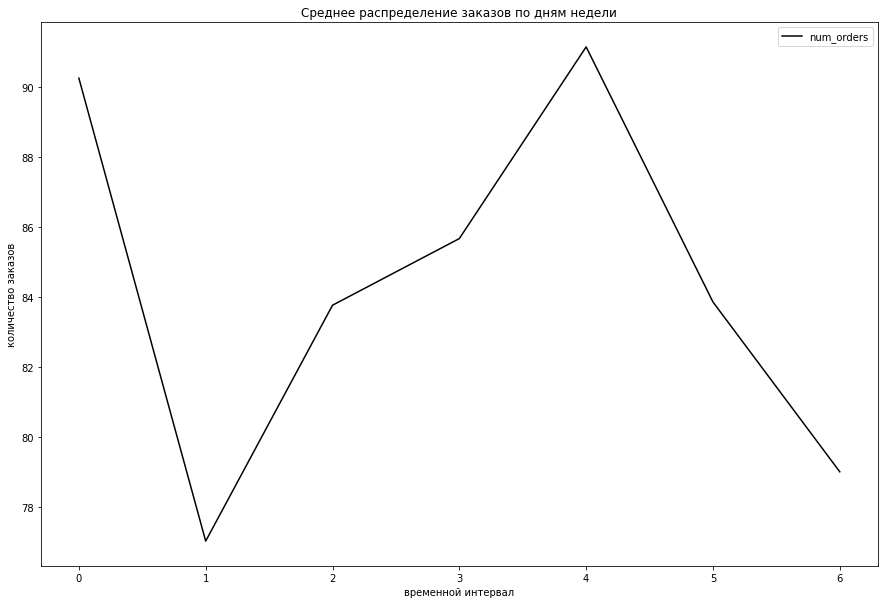

In [10]:
data['dayofweek'] = data.index.dayofweek
dayofweek_pivot = pd.pivot_table(data, values='num_orders', index='dayofweek', aggfunc='mean')

dayofweek_pivot.plot(color='black')
plt.title('Среднее распределение заказов по дням недели')
plt.xlabel('временной интервал') 
plt.ylabel('количество заказов')
plt.show()

На графиках изобразил скользящее среднее и скользящее стандартное отклонение с размером окна, равным 15,наблюдаем нестационарный процесс в первом графике, после изменения разности временного ряда, ряд стал более стационарным.Пики заказов во вторник и воскресенье.

- Нулевая : гипотеза о нестацинарности ряда.
- Альтернативная : гипотеза о стационарности ряда.

In [11]:
alpha = .05

result = adfuller(df)

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[1] < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

ADF Statistic: -3.068924
p-value: 0.028940
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Отвергаем нулевую гипотезу


При проверки гипотезы с помощью теста Дики-Фуллера при уровне значимости 5%,так же значение t-статистики -3,06 больше значений на 5% и 10% доверительных интервалах, можно прийти к выводу что ряд стационарный.

## Обучение

In [12]:
def make_features(dataframe, max_lag, rolling_mean_size):
    data = dataframe.copy(deep=True)
    data['hour'] = data.index.hour
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    return data

In [13]:
df = make_features(df, 30, 5)    

Написал функцию make_features(), чтобы прибавить к таблице три новых календарных признака: час, день и день недели,
добавить новый аргумент max_lag, который задаст максимальный размер отставания и вычислил скользящее среднее и добавил его как признак 'rolling_mean', добавил новый аргумент rolling_mean_size, который задаст ширину окна.

In [14]:
train, test = train_test_split(df, test_size=TEST_SIZE, random_state=RANDOM_STATE, shuffle=False)
train = train.dropna()

y_train = train['num_orders']
X_train = train.drop('num_orders', axis=1)

y_test = test['num_orders']
X_test = test.drop('num_orders', axis=1)

Разбил выборку на тренировочную и тестовую в соотношении 90/10

In [15]:
time_split = TimeSeriesSplit(n_splits=3)

### Обучение CatBoostRegressor

In [16]:
model_cbr = CatBoostRegressor(random_state=RANDOM_STATE)

In [17]:
parameters = {'depth' : [6,8,10],
              'learning_rate' : [0.01, 0.05, 0.1],
              'iterations'    : [10, 50, 100]
              }

grid_cbr = GridSearchCV(estimator=model_cbr, 
                        param_grid = parameters, 
                        cv = time_split, n_jobs=-1, 
                        scoring='neg_mean_squared_error'
)

In [18]:
grid_cbr.fit(X_train, y_train)

0:	learn: 29.2191435	total: 53.9ms	remaining: 485ms
1:	learn: 29.0907837	total: 58.5ms	remaining: 234ms
2:	learn: 28.9709173	total: 63ms	remaining: 147ms
3:	learn: 28.8340479	total: 67.6ms	remaining: 101ms
4:	learn: 28.6968303	total: 72.1ms	remaining: 72.1ms
5:	learn: 28.5664373	total: 76.4ms	remaining: 50.9ms
6:	learn: 28.4430952	total: 80.8ms	remaining: 34.6ms
7:	learn: 28.3250711	total: 85.8ms	remaining: 21.4ms
8:	learn: 28.1901206	total: 90.4ms	remaining: 10ms
9:	learn: 28.0658068	total: 94.8ms	remaining: 0us
0:	learn: 31.8329653	total: 7.47ms	remaining: 67.2ms
1:	learn: 31.6854678	total: 13.3ms	remaining: 53.2ms
2:	learn: 31.5497121	total: 18.6ms	remaining: 43.4ms
3:	learn: 31.4040863	total: 24.2ms	remaining: 36.3ms
4:	learn: 31.2682278	total: 29.8ms	remaining: 29.8ms
5:	learn: 31.1399380	total: 35.1ms	remaining: 23.4ms
6:	learn: 31.0153049	total: 40.3ms	remaining: 17.3ms
7:	learn: 30.8798741	total: 45.8ms	remaining: 11.5ms
8:	learn: 30.7502305	total: 50.9ms	remaining: 5.66ms
9:	l

33:	learn: 27.9138100	total: 196ms	remaining: 92.2ms
34:	learn: 27.8170687	total: 202ms	remaining: 86.5ms
35:	learn: 27.7183759	total: 208ms	remaining: 80.8ms
36:	learn: 27.6198260	total: 214ms	remaining: 75.1ms
37:	learn: 27.5198164	total: 222ms	remaining: 70ms
38:	learn: 27.4168803	total: 231ms	remaining: 65ms
39:	learn: 27.3192002	total: 240ms	remaining: 59.9ms
40:	learn: 27.2229492	total: 248ms	remaining: 54.5ms
41:	learn: 27.1384208	total: 258ms	remaining: 49ms
42:	learn: 27.0495622	total: 266ms	remaining: 43.4ms
43:	learn: 26.9695263	total: 272ms	remaining: 37.1ms
44:	learn: 26.8919221	total: 277ms	remaining: 30.8ms
45:	learn: 26.8055455	total: 283ms	remaining: 24.6ms
46:	learn: 26.7269550	total: 288ms	remaining: 18.4ms
47:	learn: 26.6428415	total: 294ms	remaining: 12.2ms
48:	learn: 26.5589541	total: 299ms	remaining: 6.1ms
49:	learn: 26.4701491	total: 304ms	remaining: 0us
0:	learn: 33.7700271	total: 6.61ms	remaining: 324ms
1:	learn: 33.6198665	total: 12.8ms	remaining: 308ms
2:	le

0:	learn: 33.1463111	total: 7.99ms	remaining: 392ms
1:	learn: 32.4342091	total: 18.3ms	remaining: 439ms
2:	learn: 31.7436093	total: 28.9ms	remaining: 453ms
3:	learn: 31.0920719	total: 37.3ms	remaining: 429ms
4:	learn: 30.4793546	total: 44ms	remaining: 396ms
5:	learn: 29.9020982	total: 52.5ms	remaining: 385ms
6:	learn: 29.4139223	total: 62.2ms	remaining: 382ms
7:	learn: 28.8993556	total: 72.3ms	remaining: 380ms
8:	learn: 28.4285497	total: 82.1ms	remaining: 374ms
9:	learn: 27.9586619	total: 89.9ms	remaining: 360ms
10:	learn: 27.5526511	total: 98.2ms	remaining: 348ms
11:	learn: 27.1278560	total: 109ms	remaining: 345ms
12:	learn: 26.7559872	total: 116ms	remaining: 331ms
13:	learn: 26.4099297	total: 123ms	remaining: 316ms
14:	learn: 26.1009197	total: 133ms	remaining: 310ms
15:	learn: 25.7837866	total: 140ms	remaining: 298ms
16:	learn: 25.4748485	total: 147ms	remaining: 285ms
17:	learn: 25.2111125	total: 153ms	remaining: 273ms
18:	learn: 24.9452542	total: 160ms	remaining: 261ms
19:	learn: 24

30:	learn: 20.4470853	total: 203ms	remaining: 124ms
31:	learn: 20.3759408	total: 209ms	remaining: 117ms
32:	learn: 20.2935894	total: 215ms	remaining: 111ms
33:	learn: 20.1627616	total: 221ms	remaining: 104ms
34:	learn: 20.0592219	total: 228ms	remaining: 97.5ms
35:	learn: 19.9961307	total: 233ms	remaining: 90.7ms
36:	learn: 19.9164482	total: 239ms	remaining: 84ms
37:	learn: 19.8461979	total: 245ms	remaining: 77.5ms
38:	learn: 19.7797117	total: 251ms	remaining: 70.9ms
39:	learn: 19.7365501	total: 257ms	remaining: 64.4ms
40:	learn: 19.6687811	total: 264ms	remaining: 57.9ms
41:	learn: 19.6034773	total: 270ms	remaining: 51.4ms
42:	learn: 19.5270278	total: 277ms	remaining: 45ms
43:	learn: 19.4884682	total: 283ms	remaining: 38.5ms
44:	learn: 19.4285066	total: 289ms	remaining: 32.1ms
45:	learn: 19.3699032	total: 295ms	remaining: 25.6ms
46:	learn: 19.3231289	total: 301ms	remaining: 19.2ms
47:	learn: 19.2716549	total: 310ms	remaining: 12.9ms
48:	learn: 19.2127918	total: 320ms	remaining: 6.52ms
4

61:	learn: 25.5246159	total: 385ms	remaining: 236ms
62:	learn: 25.4469594	total: 391ms	remaining: 229ms
63:	learn: 25.3794206	total: 396ms	remaining: 223ms
64:	learn: 25.3030893	total: 402ms	remaining: 217ms
65:	learn: 25.2348457	total: 408ms	remaining: 210ms
66:	learn: 25.1598743	total: 413ms	remaining: 203ms
67:	learn: 25.0964452	total: 419ms	remaining: 197ms
68:	learn: 25.0344954	total: 424ms	remaining: 191ms
69:	learn: 24.9676562	total: 429ms	remaining: 184ms
70:	learn: 24.9107522	total: 435ms	remaining: 178ms
71:	learn: 24.8451485	total: 441ms	remaining: 171ms
72:	learn: 24.7723402	total: 447ms	remaining: 165ms
73:	learn: 24.7112838	total: 453ms	remaining: 159ms
74:	learn: 24.6509914	total: 458ms	remaining: 153ms
75:	learn: 24.5915806	total: 464ms	remaining: 146ms
76:	learn: 24.5336173	total: 469ms	remaining: 140ms
77:	learn: 24.4760803	total: 475ms	remaining: 134ms
78:	learn: 24.4169923	total: 480ms	remaining: 128ms
79:	learn: 24.3591145	total: 485ms	remaining: 121ms
80:	learn: 2

40:	learn: 17.9614275	total: 188ms	remaining: 270ms
41:	learn: 17.8799218	total: 192ms	remaining: 266ms
42:	learn: 17.7528966	total: 196ms	remaining: 260ms
43:	learn: 17.6522707	total: 201ms	remaining: 256ms
44:	learn: 17.5646207	total: 206ms	remaining: 251ms
45:	learn: 17.4509547	total: 210ms	remaining: 247ms
46:	learn: 17.3362904	total: 214ms	remaining: 242ms
47:	learn: 17.2548350	total: 219ms	remaining: 237ms
48:	learn: 17.1978671	total: 223ms	remaining: 232ms
49:	learn: 17.1238020	total: 228ms	remaining: 228ms
50:	learn: 17.0491999	total: 232ms	remaining: 223ms
51:	learn: 16.9820331	total: 237ms	remaining: 219ms
52:	learn: 16.9093928	total: 244ms	remaining: 216ms
53:	learn: 16.8132643	total: 251ms	remaining: 214ms
54:	learn: 16.7507320	total: 255ms	remaining: 209ms
55:	learn: 16.6863113	total: 260ms	remaining: 204ms
56:	learn: 16.6045820	total: 265ms	remaining: 200ms
57:	learn: 16.5459070	total: 269ms	remaining: 195ms
58:	learn: 16.4642775	total: 274ms	remaining: 190ms
59:	learn: 1

0:	learn: 33.1463111	total: 6.61ms	remaining: 654ms
1:	learn: 32.4342091	total: 13.1ms	remaining: 643ms
2:	learn: 31.7436093	total: 19.1ms	remaining: 619ms
3:	learn: 31.0920719	total: 25ms	remaining: 600ms
4:	learn: 30.4793546	total: 31.2ms	remaining: 593ms
5:	learn: 29.9020982	total: 37.6ms	remaining: 590ms
6:	learn: 29.4139223	total: 43.7ms	remaining: 581ms
7:	learn: 28.8993556	total: 50.3ms	remaining: 579ms
8:	learn: 28.4285497	total: 56.5ms	remaining: 572ms
9:	learn: 27.9586619	total: 62.5ms	remaining: 563ms
10:	learn: 27.5526511	total: 69ms	remaining: 559ms
11:	learn: 27.1278560	total: 75.7ms	remaining: 555ms
12:	learn: 26.7559872	total: 81.8ms	remaining: 547ms
13:	learn: 26.4099297	total: 88.1ms	remaining: 541ms
14:	learn: 26.1009197	total: 94.6ms	remaining: 536ms
15:	learn: 25.7837866	total: 101ms	remaining: 529ms
16:	learn: 25.4748485	total: 107ms	remaining: 523ms
17:	learn: 25.2111125	total: 114ms	remaining: 519ms
18:	learn: 24.9452542	total: 120ms	remaining: 513ms
19:	learn: 

74:	learn: 13.1584300	total: 373ms	remaining: 124ms
75:	learn: 13.1141834	total: 378ms	remaining: 119ms
76:	learn: 13.0648114	total: 383ms	remaining: 114ms
77:	learn: 13.0350482	total: 388ms	remaining: 109ms
78:	learn: 12.9722230	total: 393ms	remaining: 104ms
79:	learn: 12.9494341	total: 397ms	remaining: 99.3ms
80:	learn: 12.9428426	total: 402ms	remaining: 94.3ms
81:	learn: 12.9133132	total: 406ms	remaining: 89.2ms
82:	learn: 12.7843607	total: 411ms	remaining: 84.3ms
83:	learn: 12.7132667	total: 416ms	remaining: 79.2ms
84:	learn: 12.6750491	total: 420ms	remaining: 74.2ms
85:	learn: 12.6677477	total: 425ms	remaining: 69.2ms
86:	learn: 12.5801149	total: 430ms	remaining: 64.2ms
87:	learn: 12.5733604	total: 434ms	remaining: 59.2ms
88:	learn: 12.5033404	total: 439ms	remaining: 54.3ms
89:	learn: 12.4387802	total: 443ms	remaining: 49.2ms
90:	learn: 12.3800399	total: 448ms	remaining: 44.3ms
91:	learn: 12.3739352	total: 452ms	remaining: 39.3ms
92:	learn: 12.3153322	total: 457ms	remaining: 34.4m

56:	learn: 18.8168295	total: 391ms	remaining: 295ms
57:	learn: 18.7817540	total: 398ms	remaining: 288ms
58:	learn: 18.7551368	total: 408ms	remaining: 283ms
59:	learn: 18.7219280	total: 418ms	remaining: 279ms
60:	learn: 18.6922728	total: 428ms	remaining: 273ms
61:	learn: 18.6677350	total: 437ms	remaining: 268ms
62:	learn: 18.6251046	total: 445ms	remaining: 262ms
63:	learn: 18.5812353	total: 452ms	remaining: 254ms
64:	learn: 18.5331019	total: 458ms	remaining: 247ms
65:	learn: 18.4767598	total: 465ms	remaining: 239ms
66:	learn: 18.4324923	total: 471ms	remaining: 232ms
67:	learn: 18.3945088	total: 477ms	remaining: 225ms
68:	learn: 18.3520117	total: 487ms	remaining: 219ms
69:	learn: 18.3322477	total: 496ms	remaining: 213ms
70:	learn: 18.3010190	total: 503ms	remaining: 206ms
71:	learn: 18.2354660	total: 513ms	remaining: 199ms
72:	learn: 18.1943757	total: 523ms	remaining: 193ms
73:	learn: 18.1497075	total: 532ms	remaining: 187ms
74:	learn: 18.0960880	total: 541ms	remaining: 180ms
75:	learn: 1

25:	learn: 26.3631592	total: 422ms	remaining: 390ms
26:	learn: 26.2576948	total: 437ms	remaining: 372ms
27:	learn: 26.1559146	total: 451ms	remaining: 354ms
28:	learn: 26.0552750	total: 465ms	remaining: 337ms
29:	learn: 25.9503280	total: 479ms	remaining: 319ms
30:	learn: 25.8483284	total: 493ms	remaining: 302ms
31:	learn: 25.7566938	total: 508ms	remaining: 286ms
32:	learn: 25.6508607	total: 522ms	remaining: 269ms
33:	learn: 25.5552038	total: 537ms	remaining: 252ms
34:	learn: 25.4656343	total: 551ms	remaining: 236ms
35:	learn: 25.3686883	total: 566ms	remaining: 220ms
36:	learn: 25.2741269	total: 580ms	remaining: 204ms
37:	learn: 25.1870207	total: 594ms	remaining: 188ms
38:	learn: 25.0924909	total: 608ms	remaining: 172ms
39:	learn: 24.9872247	total: 623ms	remaining: 156ms
40:	learn: 24.8819433	total: 637ms	remaining: 140ms
41:	learn: 24.8027893	total: 652ms	remaining: 124ms
42:	learn: 24.7166672	total: 667ms	remaining: 109ms
43:	learn: 24.6368729	total: 682ms	remaining: 93ms
44:	learn: 24

40:	learn: 16.8484722	total: 640ms	remaining: 140ms
41:	learn: 16.7330366	total: 655ms	remaining: 125ms
42:	learn: 16.5831955	total: 670ms	remaining: 109ms
43:	learn: 16.4916436	total: 684ms	remaining: 93.3ms
44:	learn: 16.3466120	total: 699ms	remaining: 77.7ms
45:	learn: 16.2343313	total: 714ms	remaining: 62.1ms
46:	learn: 16.1396163	total: 729ms	remaining: 46.6ms
47:	learn: 16.0578448	total: 744ms	remaining: 31ms
48:	learn: 15.9589083	total: 759ms	remaining: 15.5ms
49:	learn: 15.8502292	total: 774ms	remaining: 0us
0:	learn: 31.2416178	total: 30.6ms	remaining: 1.5s
1:	learn: 30.5258787	total: 49.2ms	remaining: 1.18s
2:	learn: 29.8490314	total: 67.1ms	remaining: 1.05s
3:	learn: 29.2718461	total: 84.7ms	remaining: 974ms
4:	learn: 28.7518561	total: 103ms	remaining: 923ms
5:	learn: 28.1836833	total: 120ms	remaining: 882ms
6:	learn: 27.6449962	total: 138ms	remaining: 846ms
7:	learn: 27.1642754	total: 156ms	remaining: 819ms
8:	learn: 26.6839784	total: 174ms	remaining: 793ms
9:	learn: 26.280

0:	learn: 30.5175429	total: 30.6ms	remaining: 1.5s
1:	learn: 29.1697290	total: 48.4ms	remaining: 1.16s
2:	learn: 27.9710607	total: 67ms	remaining: 1.05s
3:	learn: 27.0064395	total: 85.4ms	remaining: 982ms
4:	learn: 26.1876781	total: 106ms	remaining: 951ms
5:	learn: 25.3415273	total: 123ms	remaining: 904ms
6:	learn: 24.5034161	total: 141ms	remaining: 868ms
7:	learn: 23.8450480	total: 159ms	remaining: 835ms
8:	learn: 23.1879603	total: 177ms	remaining: 805ms
9:	learn: 22.6402638	total: 193ms	remaining: 772ms
10:	learn: 22.1425975	total: 209ms	remaining: 742ms
11:	learn: 21.7041672	total: 226ms	remaining: 717ms
12:	learn: 21.2402924	total: 245ms	remaining: 696ms
13:	learn: 20.8787150	total: 262ms	remaining: 673ms
14:	learn: 20.4960149	total: 280ms	remaining: 652ms
15:	learn: 20.1833327	total: 297ms	remaining: 631ms
16:	learn: 19.8307882	total: 321ms	remaining: 624ms
17:	learn: 19.5811738	total: 346ms	remaining: 615ms
18:	learn: 19.3689169	total: 364ms	remaining: 593ms
19:	learn: 19.0842740

67:	learn: 22.7344508	total: 1.05s	remaining: 494ms
68:	learn: 22.6726063	total: 1.06s	remaining: 478ms
69:	learn: 22.5982773	total: 1.08s	remaining: 463ms
70:	learn: 22.5215924	total: 1.1s	remaining: 451ms
71:	learn: 22.4514365	total: 1.12s	remaining: 436ms
72:	learn: 22.3873547	total: 1.13s	remaining: 419ms
73:	learn: 22.3232300	total: 1.15s	remaining: 403ms
74:	learn: 22.2580100	total: 1.16s	remaining: 387ms
75:	learn: 22.2009242	total: 1.18s	remaining: 371ms
76:	learn: 22.1372698	total: 1.19s	remaining: 355ms
77:	learn: 22.0777502	total: 1.2s	remaining: 340ms
78:	learn: 22.0111942	total: 1.22s	remaining: 324ms
79:	learn: 21.9445293	total: 1.23s	remaining: 308ms
80:	learn: 21.8850874	total: 1.25s	remaining: 293ms
81:	learn: 21.8261940	total: 1.26s	remaining: 277ms
82:	learn: 21.7556968	total: 1.28s	remaining: 262ms
83:	learn: 21.7007945	total: 1.29s	remaining: 246ms
84:	learn: 21.6392945	total: 1.31s	remaining: 231ms
85:	learn: 21.5780764	total: 1.32s	remaining: 215ms
86:	learn: 21.

29:	learn: 29.8264093	total: 651ms	remaining: 1.52s
30:	learn: 29.7183962	total: 671ms	remaining: 1.49s
31:	learn: 29.6029140	total: 693ms	remaining: 1.47s
32:	learn: 29.4925164	total: 713ms	remaining: 1.45s
33:	learn: 29.3832072	total: 732ms	remaining: 1.42s
34:	learn: 29.2707702	total: 751ms	remaining: 1.39s
35:	learn: 29.1611464	total: 771ms	remaining: 1.37s
36:	learn: 29.0472274	total: 791ms	remaining: 1.35s
37:	learn: 28.9440643	total: 810ms	remaining: 1.32s
38:	learn: 28.8427427	total: 830ms	remaining: 1.3s
39:	learn: 28.7345871	total: 849ms	remaining: 1.27s
40:	learn: 28.6314584	total: 869ms	remaining: 1.25s
41:	learn: 28.5378982	total: 889ms	remaining: 1.23s
42:	learn: 28.4376558	total: 908ms	remaining: 1.2s
43:	learn: 28.3319019	total: 926ms	remaining: 1.18s
44:	learn: 28.2311268	total: 945ms	remaining: 1.15s
45:	learn: 28.1367162	total: 964ms	remaining: 1.13s
46:	learn: 28.0392716	total: 983ms	remaining: 1.11s
47:	learn: 27.9329853	total: 1s	remaining: 1.09s
48:	learn: 27.831

92:	learn: 12.6470769	total: 1.43s	remaining: 108ms
93:	learn: 12.5867308	total: 1.44s	remaining: 92.2ms
94:	learn: 12.5500976	total: 1.46s	remaining: 76.8ms
95:	learn: 12.5009987	total: 1.47s	remaining: 61.4ms
96:	learn: 12.4514791	total: 1.49s	remaining: 46ms
97:	learn: 12.4148380	total: 1.5s	remaining: 30.7ms
98:	learn: 12.3817931	total: 1.52s	remaining: 15.3ms
99:	learn: 12.3391161	total: 1.53s	remaining: 0us
0:	learn: 31.2416178	total: 31.2ms	remaining: 3.09s
1:	learn: 30.5258787	total: 50.1ms	remaining: 2.46s
2:	learn: 29.8490314	total: 68.3ms	remaining: 2.21s
3:	learn: 29.2718461	total: 85.8ms	remaining: 2.06s
4:	learn: 28.7518561	total: 104ms	remaining: 1.97s
5:	learn: 28.1836833	total: 129ms	remaining: 2.02s
6:	learn: 27.6449962	total: 156ms	remaining: 2.07s
7:	learn: 27.1642754	total: 183ms	remaining: 2.1s
8:	learn: 26.6839784	total: 209ms	remaining: 2.11s
9:	learn: 26.2807700	total: 231ms	remaining: 2.08s
10:	learn: 25.7984730	total: 250ms	remaining: 2.02s
11:	learn: 25.4078

52:	learn: 19.5995130	total: 1.07s	remaining: 952ms
53:	learn: 19.5498753	total: 1.1s	remaining: 939ms
54:	learn: 19.4782038	total: 1.13s	remaining: 927ms
55:	learn: 19.4207233	total: 1.16s	remaining: 913ms
56:	learn: 19.3504069	total: 1.19s	remaining: 900ms
57:	learn: 19.2817106	total: 1.22s	remaining: 881ms
58:	learn: 19.2145664	total: 1.24s	remaining: 859ms
59:	learn: 19.1550536	total: 1.25s	remaining: 837ms
60:	learn: 19.0952786	total: 1.27s	remaining: 815ms
61:	learn: 19.0199103	total: 1.29s	remaining: 793ms
62:	learn: 18.9586811	total: 1.31s	remaining: 772ms
63:	learn: 18.9079063	total: 1.33s	remaining: 751ms
64:	learn: 18.8618721	total: 1.35s	remaining: 730ms
65:	learn: 18.8215674	total: 1.38s	remaining: 709ms
66:	learn: 18.7693571	total: 1.39s	remaining: 687ms
67:	learn: 18.7169629	total: 1.41s	remaining: 666ms
68:	learn: 18.6641719	total: 1.43s	remaining: 645ms
69:	learn: 18.6234216	total: 1.46s	remaining: 624ms
70:	learn: 18.5487911	total: 1.48s	remaining: 603ms
71:	learn: 18

11:	learn: 21.7041672	total: 253ms	remaining: 1.85s
12:	learn: 21.2402924	total: 273ms	remaining: 1.83s
13:	learn: 20.8787150	total: 291ms	remaining: 1.79s
14:	learn: 20.4960149	total: 310ms	remaining: 1.75s
15:	learn: 20.1833327	total: 328ms	remaining: 1.72s
16:	learn: 19.8307882	total: 346ms	remaining: 1.69s
17:	learn: 19.5811738	total: 365ms	remaining: 1.66s
18:	learn: 19.3689169	total: 384ms	remaining: 1.64s
19:	learn: 19.0842740	total: 401ms	remaining: 1.6s
20:	learn: 18.8418359	total: 420ms	remaining: 1.58s
21:	learn: 18.6101023	total: 439ms	remaining: 1.56s
22:	learn: 18.3868580	total: 457ms	remaining: 1.53s
23:	learn: 18.2532022	total: 474ms	remaining: 1.5s
24:	learn: 18.0981528	total: 492ms	remaining: 1.47s
25:	learn: 17.9357918	total: 508ms	remaining: 1.45s
26:	learn: 17.7946694	total: 526ms	remaining: 1.42s
27:	learn: 17.6191622	total: 543ms	remaining: 1.4s
28:	learn: 17.4417802	total: 561ms	remaining: 1.37s
29:	learn: 17.2755566	total: 579ms	remaining: 1.35s
30:	learn: 17.1

78:	learn: 15.5531861	total: 1.66s	remaining: 441ms
79:	learn: 15.5034314	total: 1.68s	remaining: 420ms
80:	learn: 15.4301473	total: 1.7s	remaining: 398ms
81:	learn: 15.3763910	total: 1.72s	remaining: 377ms
82:	learn: 15.3139675	total: 1.74s	remaining: 356ms
83:	learn: 15.2300822	total: 1.76s	remaining: 335ms
84:	learn: 15.1868151	total: 1.77s	remaining: 313ms
85:	learn: 15.1096941	total: 1.79s	remaining: 292ms
86:	learn: 15.0456172	total: 1.81s	remaining: 271ms
87:	learn: 15.0121317	total: 1.83s	remaining: 250ms
88:	learn: 14.9649669	total: 1.85s	remaining: 229ms
89:	learn: 14.8975852	total: 1.87s	remaining: 208ms
90:	learn: 14.8563786	total: 1.89s	remaining: 187ms
91:	learn: 14.8168614	total: 1.91s	remaining: 166ms
92:	learn: 14.7437060	total: 1.93s	remaining: 145ms
93:	learn: 14.6901344	total: 1.96s	remaining: 125ms
94:	learn: 14.6411821	total: 1.98s	remaining: 104ms
95:	learn: 14.5774868	total: 2.01s	remaining: 83.7ms
96:	learn: 14.4986324	total: 2.03s	remaining: 62.7ms
97:	learn: 

0:	learn: 31.8273469	total: 52.5ms	remaining: 2.57s
1:	learn: 31.6844629	total: 107ms	remaining: 2.56s
2:	learn: 31.5471482	total: 161ms	remaining: 2.52s
3:	learn: 31.4057498	total: 215ms	remaining: 2.48s
4:	learn: 31.2704946	total: 268ms	remaining: 2.41s
5:	learn: 31.1302273	total: 321ms	remaining: 2.35s
6:	learn: 31.0011703	total: 371ms	remaining: 2.28s
7:	learn: 30.8512695	total: 425ms	remaining: 2.23s
8:	learn: 30.7158973	total: 478ms	remaining: 2.18s
9:	learn: 30.5869086	total: 534ms	remaining: 2.13s
10:	learn: 30.4465929	total: 588ms	remaining: 2.08s
11:	learn: 30.3162847	total: 641ms	remaining: 2.03s
12:	learn: 30.1989655	total: 697ms	remaining: 1.98s
13:	learn: 30.0695662	total: 753ms	remaining: 1.94s
14:	learn: 29.9510946	total: 807ms	remaining: 1.88s
15:	learn: 29.8241332	total: 864ms	remaining: 1.84s
16:	learn: 29.6846622	total: 921ms	remaining: 1.79s
17:	learn: 29.5559082	total: 979ms	remaining: 1.74s
18:	learn: 29.4414135	total: 1.04s	remaining: 1.7s
19:	learn: 29.3079804	

12:	learn: 24.8345848	total: 678ms	remaining: 1.93s
13:	learn: 24.4263365	total: 731ms	remaining: 1.88s
14:	learn: 24.0716458	total: 783ms	remaining: 1.83s
15:	learn: 23.7323946	total: 834ms	remaining: 1.77s
16:	learn: 23.3603969	total: 886ms	remaining: 1.72s
17:	learn: 23.0296300	total: 939ms	remaining: 1.67s
18:	learn: 22.7427217	total: 989ms	remaining: 1.61s
19:	learn: 22.4154173	total: 1.04s	remaining: 1.56s
20:	learn: 22.1560612	total: 1.09s	remaining: 1.51s
21:	learn: 21.8989401	total: 1.15s	remaining: 1.46s
22:	learn: 21.6563211	total: 1.2s	remaining: 1.41s
23:	learn: 21.4044801	total: 1.25s	remaining: 1.35s
24:	learn: 21.1720568	total: 1.3s	remaining: 1.3s
25:	learn: 20.9110833	total: 1.37s	remaining: 1.27s
26:	learn: 20.6863208	total: 1.42s	remaining: 1.21s
27:	learn: 20.4633964	total: 1.48s	remaining: 1.16s
28:	learn: 20.2664111	total: 1.54s	remaining: 1.12s
29:	learn: 20.0701253	total: 1.59s	remaining: 1.06s
30:	learn: 19.8104262	total: 1.65s	remaining: 1.01s
31:	learn: 19.5

24:	learn: 16.7717737	total: 1.3s	remaining: 1.3s
25:	learn: 16.5418243	total: 1.36s	remaining: 1.25s
26:	learn: 16.3421823	total: 1.41s	remaining: 1.2s
27:	learn: 16.1121921	total: 1.46s	remaining: 1.14s
28:	learn: 15.8909436	total: 1.52s	remaining: 1.1s
29:	learn: 15.7174374	total: 1.57s	remaining: 1.05s
30:	learn: 15.5356439	total: 1.62s	remaining: 995ms
31:	learn: 15.3691171	total: 1.67s	remaining: 941ms
32:	learn: 15.1750608	total: 1.72s	remaining: 888ms
33:	learn: 14.9897537	total: 1.77s	remaining: 835ms
34:	learn: 14.8334700	total: 1.82s	remaining: 782ms
35:	learn: 14.6851831	total: 1.88s	remaining: 730ms
36:	learn: 14.4838428	total: 1.93s	remaining: 679ms
37:	learn: 14.3291763	total: 1.98s	remaining: 627ms
38:	learn: 14.2184644	total: 2.04s	remaining: 575ms
39:	learn: 14.0738966	total: 2.09s	remaining: 523ms
40:	learn: 13.8919291	total: 2.14s	remaining: 470ms
41:	learn: 13.7443987	total: 2.19s	remaining: 417ms
42:	learn: 13.5950184	total: 2.25s	remaining: 366ms
43:	learn: 13.46

84:	learn: 21.5251861	total: 3.71s	remaining: 655ms
85:	learn: 21.4556443	total: 3.76s	remaining: 612ms
86:	learn: 21.3830246	total: 3.8s	remaining: 568ms
87:	learn: 21.3195724	total: 3.84s	remaining: 523ms
88:	learn: 21.2478297	total: 3.88s	remaining: 480ms
89:	learn: 21.1866266	total: 3.92s	remaining: 436ms
90:	learn: 21.1286459	total: 3.97s	remaining: 392ms
91:	learn: 21.0665375	total: 4.01s	remaining: 349ms
92:	learn: 20.9987136	total: 4.05s	remaining: 305ms
93:	learn: 20.9356379	total: 4.09s	remaining: 261ms
94:	learn: 20.8733925	total: 4.13s	remaining: 217ms
95:	learn: 20.8143595	total: 4.17s	remaining: 174ms
96:	learn: 20.7537778	total: 4.21s	remaining: 130ms
97:	learn: 20.6917497	total: 4.25s	remaining: 86.8ms
98:	learn: 20.6327791	total: 4.3s	remaining: 43.4ms
99:	learn: 20.5774542	total: 4.34s	remaining: 0us
0:	learn: 31.8273469	total: 52.6ms	remaining: 5.21s
1:	learn: 31.6844629	total: 103ms	remaining: 5.05s
2:	learn: 31.5471482	total: 156ms	remaining: 5.03s
3:	learn: 31.405

44:	learn: 28.2142284	total: 2.61s	remaining: 3.19s
45:	learn: 28.1144982	total: 2.67s	remaining: 3.13s
46:	learn: 28.0219160	total: 2.72s	remaining: 3.07s
47:	learn: 27.9262050	total: 2.78s	remaining: 3.01s
48:	learn: 27.8169261	total: 2.83s	remaining: 2.95s
49:	learn: 27.7159297	total: 2.89s	remaining: 2.89s
50:	learn: 27.6224015	total: 2.95s	remaining: 2.83s
51:	learn: 27.5303340	total: 3s	remaining: 2.77s
52:	learn: 27.4366643	total: 3.06s	remaining: 2.71s
53:	learn: 27.3492797	total: 3.12s	remaining: 2.65s
54:	learn: 27.2573227	total: 3.19s	remaining: 2.61s
55:	learn: 27.1703735	total: 3.25s	remaining: 2.55s
56:	learn: 27.0817880	total: 3.31s	remaining: 2.5s
57:	learn: 26.9951987	total: 3.36s	remaining: 2.44s
58:	learn: 26.9036575	total: 3.42s	remaining: 2.38s
59:	learn: 26.8143095	total: 3.48s	remaining: 2.32s
60:	learn: 26.7253327	total: 3.53s	remaining: 2.26s
61:	learn: 26.6386699	total: 3.6s	remaining: 2.21s
62:	learn: 26.5455494	total: 3.67s	remaining: 2.16s
63:	learn: 26.458

4:	learn: 28.7190862	total: 278ms	remaining: 5.28s
5:	learn: 28.1473089	total: 334ms	remaining: 5.22s
6:	learn: 27.6339845	total: 388ms	remaining: 5.16s
7:	learn: 27.0579870	total: 438ms	remaining: 5.03s
8:	learn: 26.5781052	total: 486ms	remaining: 4.92s
9:	learn: 26.0864276	total: 534ms	remaining: 4.81s
10:	learn: 25.6713261	total: 588ms	remaining: 4.76s
11:	learn: 25.2124074	total: 641ms	remaining: 4.7s
12:	learn: 24.8345848	total: 694ms	remaining: 4.64s
13:	learn: 24.4263365	total: 760ms	remaining: 4.67s
14:	learn: 24.0716458	total: 813ms	remaining: 4.61s
15:	learn: 23.7323946	total: 866ms	remaining: 4.54s
16:	learn: 23.3603969	total: 917ms	remaining: 4.48s
17:	learn: 23.0296300	total: 971ms	remaining: 4.42s
18:	learn: 22.7427217	total: 1.02s	remaining: 4.36s
19:	learn: 22.4154173	total: 1.07s	remaining: 4.29s
20:	learn: 22.1560612	total: 1.12s	remaining: 4.22s
21:	learn: 21.8989401	total: 1.18s	remaining: 4.17s
22:	learn: 21.6563211	total: 1.23s	remaining: 4.11s
23:	learn: 21.40448

66:	learn: 17.0318068	total: 4.04s	remaining: 1.99s
67:	learn: 16.9600238	total: 4.09s	remaining: 1.93s
68:	learn: 16.8744861	total: 4.15s	remaining: 1.86s
69:	learn: 16.8004770	total: 4.21s	remaining: 1.8s
70:	learn: 16.7162147	total: 4.28s	remaining: 1.75s
71:	learn: 16.6562044	total: 4.36s	remaining: 1.69s
72:	learn: 16.5856159	total: 4.41s	remaining: 1.63s
73:	learn: 16.5238516	total: 4.47s	remaining: 1.57s
74:	learn: 16.4545396	total: 4.53s	remaining: 1.51s
75:	learn: 16.4263166	total: 4.58s	remaining: 1.45s
76:	learn: 16.3686776	total: 4.64s	remaining: 1.39s
77:	learn: 16.3043851	total: 4.7s	remaining: 1.32s
78:	learn: 16.2204221	total: 4.75s	remaining: 1.26s
79:	learn: 16.1490677	total: 4.81s	remaining: 1.2s
80:	learn: 16.0687915	total: 4.87s	remaining: 1.14s
81:	learn: 16.0189853	total: 4.92s	remaining: 1.08s
82:	learn: 15.9360391	total: 4.98s	remaining: 1.02s
83:	learn: 15.8675457	total: 5.03s	remaining: 959ms
84:	learn: 15.8248387	total: 5.09s	remaining: 898ms
85:	learn: 15.7

28:	learn: 15.8909436	total: 1.55s	remaining: 3.81s
29:	learn: 15.7174374	total: 1.61s	remaining: 3.75s
30:	learn: 15.5356439	total: 1.66s	remaining: 3.7s
31:	learn: 15.3691171	total: 1.71s	remaining: 3.63s
32:	learn: 15.1750608	total: 1.76s	remaining: 3.58s
33:	learn: 14.9897537	total: 1.81s	remaining: 3.52s
34:	learn: 14.8334700	total: 1.86s	remaining: 3.46s
35:	learn: 14.6851831	total: 1.92s	remaining: 3.41s
36:	learn: 14.4838428	total: 1.97s	remaining: 3.35s
37:	learn: 14.3291763	total: 2.02s	remaining: 3.3s
38:	learn: 14.2184644	total: 2.08s	remaining: 3.25s
39:	learn: 14.0738966	total: 2.13s	remaining: 3.2s
40:	learn: 13.8919291	total: 2.18s	remaining: 3.14s
41:	learn: 13.7443987	total: 2.25s	remaining: 3.1s
42:	learn: 13.5950184	total: 2.3s	remaining: 3.05s
43:	learn: 13.4691525	total: 2.35s	remaining: 2.99s
44:	learn: 13.3570641	total: 2.4s	remaining: 2.93s
45:	learn: 13.2205145	total: 2.45s	remaining: 2.88s
46:	learn: 13.1027876	total: 2.52s	remaining: 2.84s
47:	learn: 13.0442

88:	learn: 11.7562849	total: 5.16s	remaining: 638ms
89:	learn: 11.6821525	total: 5.21s	remaining: 580ms
90:	learn: 11.5953531	total: 5.27s	remaining: 521ms
91:	learn: 11.5267057	total: 5.33s	remaining: 463ms
92:	learn: 11.4371276	total: 5.39s	remaining: 406ms
93:	learn: 11.3986386	total: 5.45s	remaining: 348ms
94:	learn: 11.3105763	total: 5.5s	remaining: 290ms
95:	learn: 11.2206114	total: 5.56s	remaining: 232ms
96:	learn: 11.1743863	total: 5.62s	remaining: 174ms
97:	learn: 11.1104151	total: 5.67s	remaining: 116ms
98:	learn: 11.1052091	total: 5.72s	remaining: 57.8ms
99:	learn: 11.0214762	total: 5.78s	remaining: 0us
0:	learn: 36.9812831	total: 9.36ms	remaining: 927ms
1:	learn: 35.4276982	total: 16.5ms	remaining: 810ms
2:	learn: 34.0165093	total: 23.7ms	remaining: 767ms
3:	learn: 32.6968209	total: 31.6ms	remaining: 759ms
4:	learn: 31.5902400	total: 39.4ms	remaining: 748ms
5:	learn: 30.6183384	total: 47.5ms	remaining: 743ms
6:	learn: 29.7939119	total: 56.9ms	remaining: 755ms
7:	learn: 29.0

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=<catboost.core.CatBoostRegressor object at 0x7f24a990ecd0>,
             n_jobs=-1,
             param_grid={'depth': [6, 8, 10], 'iterations': [10, 50, 100],
                         'learning_rate': [0.01, 0.05, 0.1]},
             scoring='neg_mean_squared_error')

In [19]:
results_cbr = grid_cbr.cv_results_
best_index_cbr = grid_cbr.best_index_

cbr_fit_time = results_cbr['mean_fit_time'][best_index_cbr]
cbr_score_time = results_cbr['mean_score_time'][best_index_cbr]
cbr_RMSE = (results_cbr['mean_test_score'][best_index_cbr] * -1) **.5

print(f"Fit time cbr: {cbr_fit_time}, Predict time cbr: {cbr_score_time}, Best RMSE cbr: {cbr_RMSE}")

Fit time cbr: 1.2898687521616619, Predict time cbr: 0.0039212703704833984, Best RMSE cbr: 26.763681987775048


### Обучение DecisionTreeRegressor

In [20]:
model_dtr = DecisionTreeRegressor(random_state=RANDOM_STATE)

In [21]:
parameters = {
    'min_samples_leaf': range(1, 30),
    'max_depth': range(2, 10)
} 

In [22]:
grid_dtr = GridSearchCV(estimator=model_dtr, 
                        param_grid = parameters, 
                        cv =time_split, n_jobs=-1, 
                        scoring='neg_mean_squared_error'
)

grid_dtr.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=DecisionTreeRegressor(random_state=37), n_jobs=-1,
             param_grid={'max_depth': range(2, 10),
                         'min_samples_leaf': range(1, 30)},
             scoring='neg_mean_squared_error')

In [23]:
results_dtr = grid_dtr.cv_results_
best_index_dtr = grid_dtr.best_index_

dtr_fit_time = results_dtr['mean_fit_time'][best_index_dtr]
dtr_score_time = results_dtr['mean_score_time'][best_index_dtr]
dtr_RMSE = (results_dtr['mean_test_score'][best_index_dtr] * -1) **.5

print(f"Fit time cbr: {dtr_fit_time}, Predict time cbr: {dtr_score_time}, Best RMSE cbr: {dtr_RMSE}")

Fit time cbr: 0.022910435994466145, Predict time cbr: 0.0024139086405436196, Best RMSE cbr: 31.258205128129923


### Обучение RandomForestRegressor

In [24]:
model_rfr = RandomForestRegressor(random_state=RANDOM_STATE)
parameters = {
    'n_estimators': [30, 40],
    'max_depth': [13, 22, 33]
}
grid_rfr = GridSearchCV(estimator=model_rfr, 
                        param_grid = parameters, 
                        cv =time_split, n_jobs=-1, 
                        scoring='neg_mean_squared_error')
grid_rfr.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=RandomForestRegressor(random_state=37), n_jobs=-1,
             param_grid={'max_depth': [13, 22, 33], 'n_estimators': [30, 40]},
             scoring='neg_mean_squared_error')

In [25]:
results_rfr = grid_rfr.cv_results_
best_index_rfr = grid_rfr.best_index_

rfr_fit_time = results_rfr['mean_fit_time'][best_index_rfr]
rfr_score_time = results_rfr['mean_score_time'][best_index_rfr]
rfr_RMSE = (results_rfr['mean_test_score'][best_index_rfr] * -1) **.5

print(f"Fit time cbr: {rfr_fit_time}, Predict time cbr: {rfr_score_time}, Best RMSE cbr: {rfr_RMSE}")

Fit time cbr: 1.3033159573872883, Predict time cbr: 0.01089787483215332, Best RMSE cbr: 27.62107331120959


### Сравнительная таблица тренировочной выборки

In [26]:
result_train = pd.DataFrame(
    [[cbr_fit_time, cbr_score_time, cbr_RMSE],
    [dtr_fit_time, dtr_score_time, dtr_RMSE],
    [rfr_fit_time, rfr_score_time, rfr_RMSE]],
    index=['CatBoostRegressor', 'DecisionTreeRegressor', 'RandomForestRegressor'],
    columns=['fit_time', 'predict_time', 'RMSE']
)
result_train

,fit_time,predict_time,RMSE
CatBoostRegressor,1.289869,0.003921,26.763682
DecisionTreeRegressor,0.022910,0.002414,31.258205
RandomForestRegressor,1.303316,0.010898,27.621073


**Вывод:** Все модели хорошо справились с предсказанием на обучающей выборке.Обучил 'CatBoostRegressor', 'DecisionTreeRegressor', 'RandomForestRegressor' через автоматизированный поиск гиперпараметров GridSearchCV, метрика RMSE = 26.8 лучше всех у CatBoostRegressor, с параметрами depth : [6,8,10],learning_rate : [0.01, 0.05, 0.1] и iterations: [10, 50, 100], с относительно небольшим средним временем затраченным на обучение.


## Тестирование лучшей модели

### Тестирование CatBoostRegressor

In [27]:
predict_test_cbr = grid_cbr.predict(X_test)
rmse_cbr = mean_squared_error(y_test, predict_test_cbr) ** .5
rmse_cbr

43.15207084897993

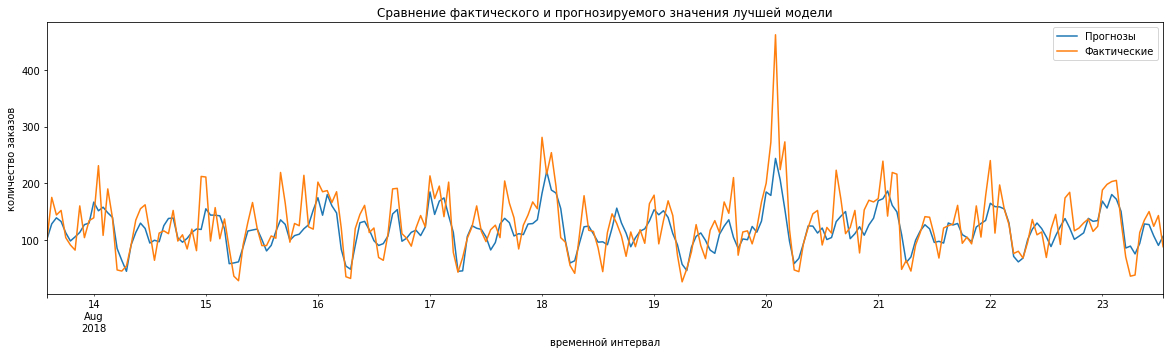

In [28]:
pd.DataFrame({'Прогнозы':predict_test_cbr,
             'Фактические':y_test})[:240].plot(figsize=(20,5))
plt.title('Сравнение фактического и прогнозируемого значения лучшей модели')
plt.xlabel('временной интервал') 
plt.ylabel('количество заказов') 
plt.show()

При сравнении фактического и прогнозируемого значения лучшей модели,мы видим что модель ошибается при пиковых значениях и при просадках в заках,а вот в средних участках ряда предсказывает хорошо.

**Вывод:** Метрика лучшей модели(CatBoostRegressor) на тестовых данных RMSE= 43.1, условие "Значение метрики RMSE на тестовой выборке должно быть не больше 48" выполнено.

## Итоговый вывод

По итогам проделанной работы было сделанно следующее:
### Открыл файл с данными и изучил иформацию
- Загрузил данные
- Вывел первые строки,изучил общую информацию.Данные представлены в 2 столбцах и  26496 строках
- Проверил, в хронологическом ли порядке расположены даты и время и выполнил их ресемплирование по одному часу
### Провел анализ
- Разложил временной ряд на три составляющие: тренд, сезонность и остаток.Наблюдаю плавный рост тренда от начала марта до конца августа
- Посмотрел сезонность в разрезе 3-х дней, 2-х недель и месяца.На *дневном* графике видим цикличный подъем с 6 утра до 12 ночи,а после спад до 6 утра
- На графиках изобразил скользящее среднее и скользящее стандартное отклонение с шагом и размером окна, равным 7, после изменения разности временного ряда, ряд стал более стационарным.Пики заказов во вторник и воскресенье.
### Обучил модели
- Написал функцию make_features(), чтобы прибавить к таблице три новых календарных признака: час, день и день недели, добавить новый аргумент max_lag, который задаст максимальный размер отставания и вычислил скользящее среднее и добавил его как признак 'rolling_mean', добавил новый аргумент rolling_mean_size, который задаст ширину окна.
- Разделил данные на тестовые и тренировочные(90/10)
- Обучил модели CatBoostRegressor, DecisionTreeRegressor и  RandomForestRegressor c подбором лучших гиперпараметров через GridSearchCV
- Проверил время обучения и предсказания на всех моделях и метрику RMSE
- Вывел сравнительную таблицу
- Лучшей моделю по метрике и времени обучения оказалась CatBoostRegressor
### Проверил на тестовой выборки
- Сделал предсказание на тестовых данных,RMSE лучшей модели на тестовых данных получился 43.15
- Вывел сравненительный график фактического и прогнозируемого значения лучшей модели.На графике мы видим что модель ошибается при пиковых значениях и при просадках в заках,а вот в средних участках ряда предсказывает хорошо.


Лучшая модель CatBoostRegressor.